### Data Prep

In [2]:
import pandas as pd

# Load the multi-batch dataset
df_multi = pd.read_csv("datasets/multi_batch_channels_dataset.csv")
df_context = pd.read_csv("datasets/sla_spc_flowrate_channels_13batches.csv")

# add resin temp, resin age, ambient temp into df_multi
df_multi["resin_temp"] = df_context["resin_temp"]
df_multi["resin_age"] = df_context["resin_age"]
df_multi["ambient_temp"] = df_context["ambient_temp"]

# drop unnessesary columns
df_multi.drop(columns="channel_diameter_mm")

# Compute per-batch mean, std, CV
batch_summary = df_multi.groupby("batch_id")["measured_flow_mL_per_min"].agg(["mean", "std"])
batch_summary["cv"] = batch_summary["std"] / batch_summary["mean"]

print("Batch-level summary:")
print(batch_summary.head())

Batch-level summary:
               mean       std        cv
batch_id                               
BATCH_001  0.373844  0.045291  0.121149
BATCH_002  0.063912  0.003787  0.059255
BATCH_003  6.468637  0.602202  0.093096
BATCH_004  0.273139  0.022820  0.083546
BATCH_005  1.438789  0.159296  0.110715


In [3]:
# ---------------------------
# Drift monitor helper
# ---------------------------
def flow_rate_drift_monitor(current_cv, baseline_cv, tolerance=0.10):
    """
    Compare current batch CV against a baseline CV
    Returns True if drift is detected (outside tolerance).
    """
    lower = baseline_cv * (1 - tolerance)
    upper = baseline_cv * (1 + tolerance)
    drift_detected = not (lower <= current_cv <= upper)
    return drift_detected, lower, upper


In [18]:
# Select features (fixed per batch)
knobs = ["resin_type", "layer_thickness_um", "orientation_deg", "support_mode", "fit_adjustment_pct"] # tunable knobs
output = [  "channel_length_mm", "channel_width_mm"] # output data from 3d print
context = [    "resin_age", "resin_temp", "ambient_temp"]  # drift context

features = knobs

# Merge batch-level CV back with batch parameters
df_batches = df_multi.groupby("batch_id").first()[features].reset_index()
df_batches = df_batches.merge(batch_summary["cv"].reset_index(), on="batch_id")

print("Prepared dataset:", df_batches.shape)
df_batches.head()

Prepared dataset: (20, 7)


,batch_id,resin_type,layer_thickness_um,orientation_deg,support_mode,fit_adjustment_pct,cv
0,BATCH_001,Resin_C,20,45,manual,0.395,0.121149
1,BATCH_002,Resin_B,100,45,manual,0.057,0.059255
2,BATCH_003,Resin_B,50,30,manual,-1.261,0.093096
3,BATCH_004,Resin_C,20,0,auto,1.948,0.083546
4,BATCH_005,Resin_A,100,60,manual,-0.901,0.110715


In [19]:
# Use mean historical CV as baseline
baseline_cv = df_batches["cv"].mean()
print(f"Baseline CV = {baseline_cv:.4f}")

Baseline CV = 0.0907


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor 

X = df_batches[features] # inputs
y = df_batches["cv"] # targets

categorical = ["resin_type", "support_mode"]
numerical = [f for f in features if f not in categorical]

preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
    ("num", "passthrough", numerical)
])

model = Pipeline([
    ("preprocess", preprocess),
    ("rf", RandomForestRegressor(n_estimators=100, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

print("Surrogate model R² on test set:", model.score(X_test, y_test))


Surrogate model R² on test set: -0.5503224931349497


In [16]:
from bayes_opt import BayesianOptimization

# Define parameter search space
pbounds = {
    "layer_thickness_um": (50, 100), # limited to 50 and 100 per dr. ava's comment
    "orientation_deg": (0, 90),
    "fit_adjustment_pct": (-2.0, 2.0),
    "resin_type": ("Resin_A", "Resin_B", "Resin_C"),
    "support_mode": ("auto", "manual")
}

def objective(**params):
    row = pd.DataFrame([params])
    # Default categorical values (can expand pbounds to include these later)
    # row["resin_type"] = "Resin_A"
    # row["support_mode"] = "auto"
    pred_cv = model.predict(row)[0]
    return -pred_cv   # minimize CV


In [25]:
from bayes_opt import BayesianOptimization

# --- Config ---
tolerance = 0.10           # ±10% drift band
max_batches = 15           # safety stop for demo
baseline_cv = df_batches["cv"].mean()   # baseline from historical data

print(f"Baseline CV = {baseline_cv:.4f}")
print("Starting Closed-Loop Optimization...\n")

# --- Initial BO setup ---
optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=42,
    verbose=0
)

# --- Initial exploration (to seed the GP model) ---
optimizer.maximize(init_points=3, n_iter=0)

batch_count = 0
stable = False

# --- Closed loop ---
while batch_count < max_batches and not stable:
    # Propose next parameters from optimizer
    next_params = optimizer.suggest()   #  no utility argument needed
    # Evaluate (this calls your surrogate and returns negative CV)
    target = objective(**next_params)
    optimizer.register(next_params, target)

    batch_count += 1
    predicted_cv = -target   # convert back (because objective returns -CV)
    drift, lower, upper = flow_rate_drift_monitor(predicted_cv, baseline_cv, tolerance)

    print(f"Batch {batch_count:02d} | Predicted CV = {predicted_cv:.4f} "
          f"| Limits [{lower:.4f}, {upper:.4f}] --> "
          f"{' Drift' if drift else ' Stable'}")

    if drift:
        # Drift detected → continue loop to propose new parameters
        pass
    else:
        # Stable → stop loop to replicate batch
        stable = True
        print(f"\n Stable batch achieved at Batch {batch_count}!")
        print("Recommended parameters to replicate:")
        print(next_params)

if not stable:
    print("\n Max batches reached without stable batch.")


Baseline CV = 0.0907
Starting Closed-Loop Optimization...



/tmp/ipykernel_19117/2654113496.py:12: UserWarning: Non-float parameters are experimental and may not work as expected. Exercise caution when using them and please report any issues you encounter.
  optimizer = BayesianOptimization(


Batch 01 | Predicted CV = 0.0862 | Limits [0.0816, 0.0998] -->  Stable

 Stable batch achieved at Batch 1!
Recommended parameters to replicate:
{'layer_thickness_um': np.float64(69.14546640898928), 'orientation_deg': np.float64(85.67207550402033), 'fit_adjustment_pct': np.float64(1.3717004396757586), 'resin_type': 'Resin_A', 'support_mode': 'manual'}


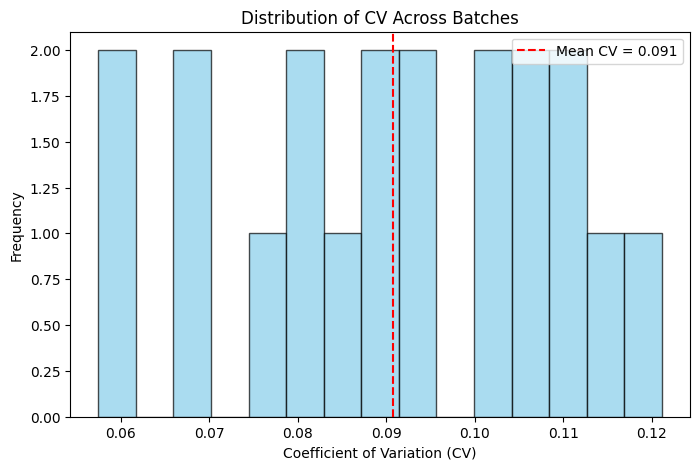

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(df_batches["cv"], bins=15, color="skyblue", edgecolor="black", alpha=0.7)
plt.axvline(df_batches["cv"].mean(), color="red", linestyle="--", label=f"Mean CV = {df_batches['cv'].mean():.3f}")
plt.title("Distribution of CV Across Batches")
plt.xlabel("Coefficient of Variation (CV)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


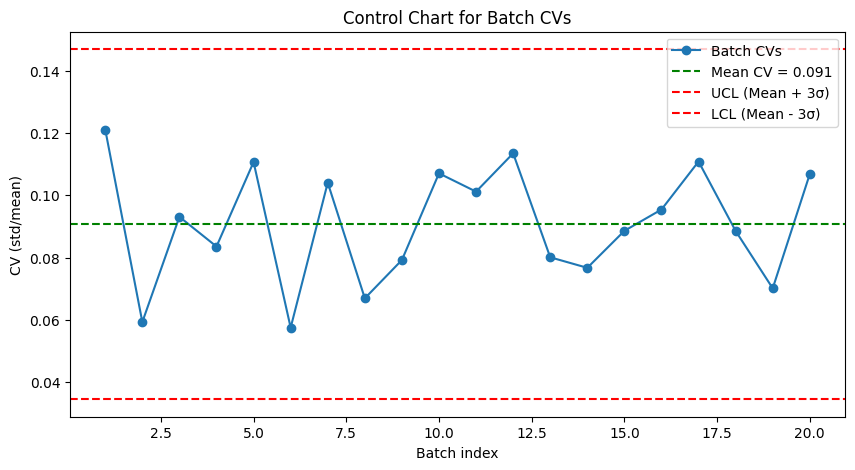

In [27]:
plt.figure(figsize=(10,5))
plt.plot(range(1, len(df_batches)+1), df_batches["cv"], marker="o", linestyle="-", label="Batch CVs")
plt.axhline(df_batches["cv"].mean(), color="green", linestyle="--", label=f"Mean CV = {df_batches['cv'].mean():.3f}")
plt.axhline(df_batches["cv"].mean() + 3*df_batches["cv"].std(), color="red", linestyle="--", label="UCL (Mean + 3σ)")
plt.axhline(df_batches["cv"].mean() - 3*df_batches["cv"].std(), color="red", linestyle="--", label="LCL (Mean - 3σ)")
plt.title("Control Chart for Batch CVs")
plt.xlabel("Batch index")
plt.ylabel("CV (std/mean)")
plt.legend()
plt.show()


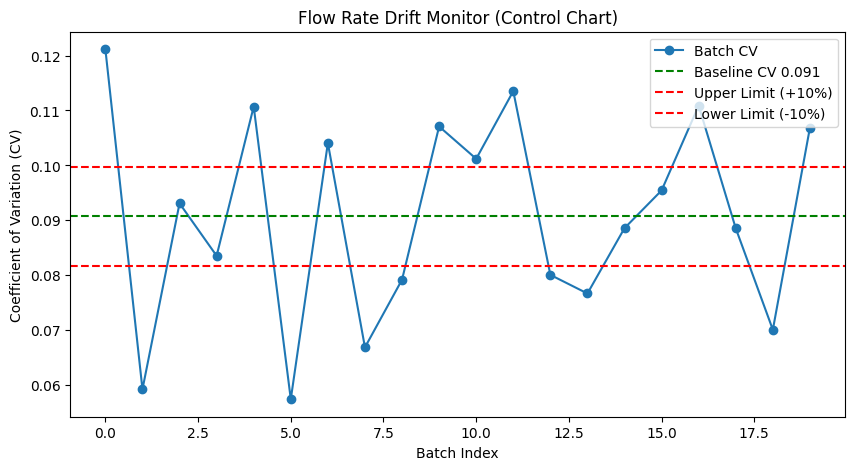

In [28]:
import matplotlib.pyplot as plt

tolerance = 0.10
lower = baseline_cv * (1 - tolerance)
upper = baseline_cv * (1 + tolerance)

plt.figure(figsize=(10,5))
plt.plot(df_batches.index, df_batches["cv"], marker="o", linestyle="-", label="Batch CV")
plt.axhline(baseline_cv, color="green", linestyle="--", label=f"Baseline CV {baseline_cv:.3f}")
plt.axhline(upper, color="red", linestyle="--", label=f"Upper Limit (+{tolerance*100:.0f}%)")
plt.axhline(lower, color="red", linestyle="--", label=f"Lower Limit (-{tolerance*100:.0f}%)")
plt.title("Flow Rate Drift Monitor (Control Chart)")
plt.xlabel("Batch Index")
plt.ylabel("Coefficient of Variation (CV)")
plt.legend()
plt.show()
